In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo 
import xgboost as xgb
  
# fetch dataset 
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938) 
  
# data (as pandas dataframes) 
X = regensburg_pediatric_appendicitis.data.features 
y = regensburg_pediatric_appendicitis.data.targets

# Merging X and y to data
data = pd.merge(X, y, left_index=True, right_index=True)
data.shape

(782, 56)

In [2]:
# deleting not needed target variables from data
data = data.drop(['Management', 'Severity'], axis=1)
data.shape

(782, 54)

In [3]:
# removing all NAN values from diagnosis
data = data.dropna(subset=['Diagnosis'])
data.shape

(780, 54)

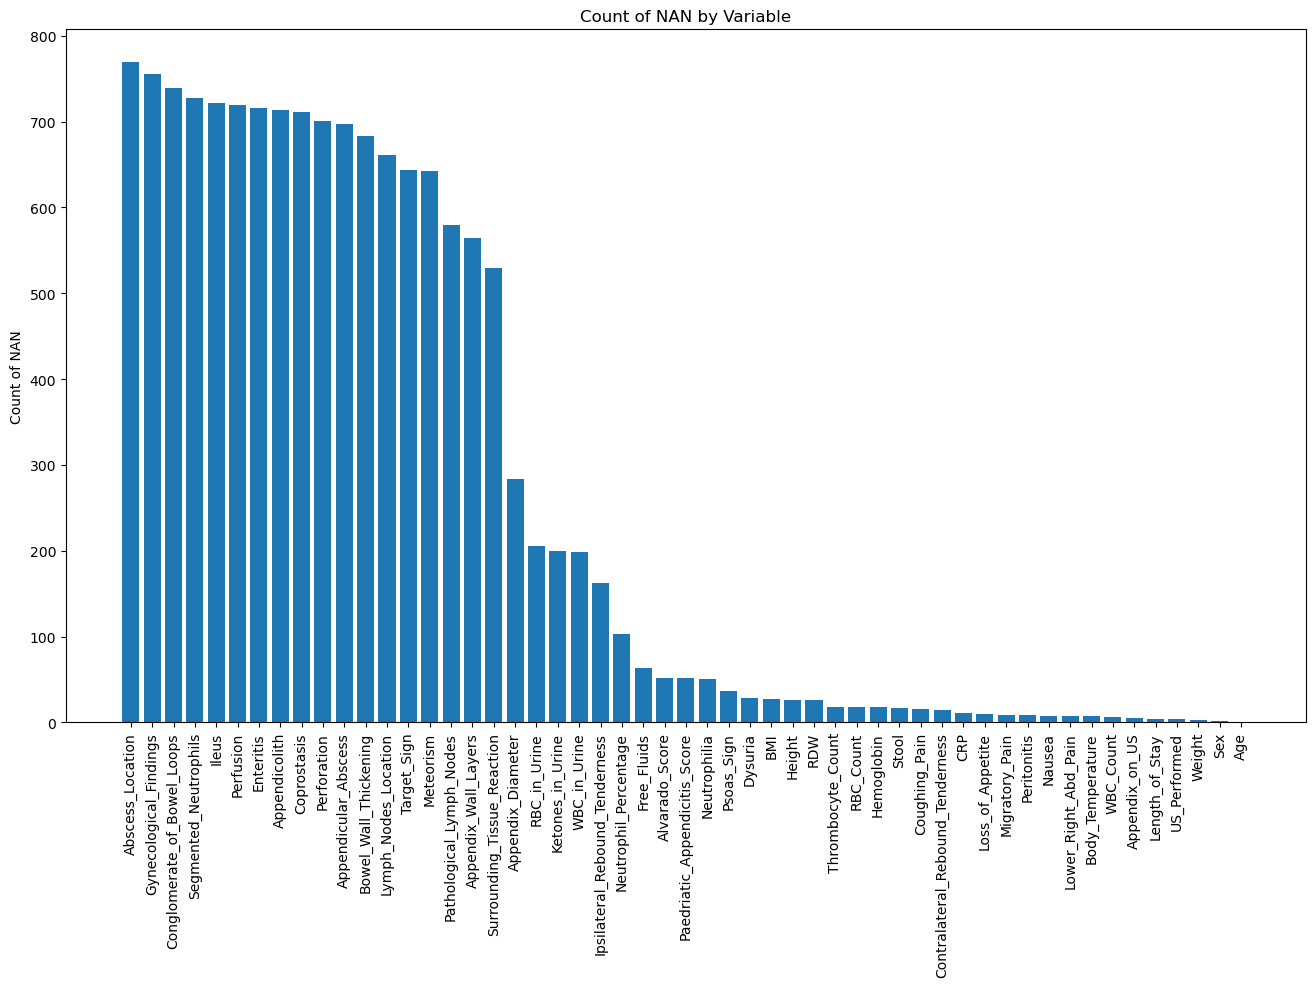

In [4]:
# visualizing count of NAN values
nan_counts = X.isna().sum()
nan_counts_sorted = nan_counts.sort_values(ascending=False)  # Sort values in descending order

plt.figure(figsize=(16, 9))
plt.bar(nan_counts_sorted.index, nan_counts_sorted.values)
plt.xticks(rotation=90)
plt.title('Count of NAN by Variable')
plt.ylabel('Count of NAN')
plt.show()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 781
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               754 non-null    float64
 2   Sex                               779 non-null    object 
 3   Height                            755 non-null    float64
 4   Weight                            778 non-null    float64
 5   Length_of_Stay                    777 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

In [6]:
object_columns = data.select_dtypes(include=['object'])
object_columns.columns

Index(['Sex', 'Appendix_on_US', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Neutrophilia', 'Ketones_in_Urine', 'RBC_in_Urine',
       'WBC_in_Urine', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign',
       'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids',
       'Appendix_Wall_Layers', 'Target_Sign', 'Appendicolith', 'Perfusion',
       'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Abscess_Location', 'Pathological_Lymph_Nodes', 'Lymph_Nodes_Location',
       'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus',
       'Coprostasis', 'Meteorism', 'Enteritis', 'Gynecological_Findings',
       'Diagnosis'],
      dtype='object')

In [7]:
# Transforming columns from text to numeric
data["Sex"] = data["Sex"].apply(lambda x: 1 if x == "female" else 0)
data["Appendix_on_US"] = data["Appendix_on_US"].apply(lambda x: 1 if x == "yes" else 0)
data["Migratory_Pain"] = data["Migratory_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Lower_Right_Abd_Pain"] = data["Lower_Right_Abd_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Contralateral_Rebound_Tenderness"] = data["Contralateral_Rebound_Tenderness"].apply(lambda x: 1 if x == "yes" else 0)
data["Coughing_Pain"] = data["Coughing_Pain"].apply(lambda x: 1 if x == "yes" else 0)
data["Nausea"] = data["Nausea"].apply(lambda x: 1 if x == "yes" else 0)
data["Loss_of_Appetite"] = data["Loss_of_Appetite"].apply(lambda x: 1 if x == "yes" else 0)
data["Neutrophilia"] = data["Neutrophilia"].apply(lambda x: 1 if x == "yes" else 0)

ketones_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["Ketones_in_Urine"] = data["Ketones_in_Urine"].map(ketones_mapping)

rbc_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["RBC_in_Urine"] = data["RBC_in_Urine"].map(rbc_mapping)

wbc_mapping = {"no": 0, "+": 1, "++": 2, "+++": 3}
data["WBC_in_Urine"] = data["WBC_in_Urine"].map(wbc_mapping)

data["Dysuria"] = data["Dysuria"].apply(lambda x: 1 if x == "yes" else 0)

stool_mapping = {"normal": 0, "diarrhea": 1, "constipation": 2, "constipation, diarrhea": 3}
data["Stool"] = data["Stool"].map(stool_mapping)

peritonitis_mapping = {"no": 0, "local": 1, "generalized": 2}
data["Peritonitis"] = data["Peritonitis"].map(peritonitis_mapping)

data["Psoas_Sign"] = data["Psoas_Sign"].apply(lambda x: 1 if x == "yes" else 0)
data["Ipsilateral_Rebound_Tenderness"] = data["Ipsilateral_Rebound_Tenderness"].apply(lambda x: 1 if x == "yes" else 0)
data["US_Performed"] = data["US_Performed"].apply(lambda x: 1 if x == "yes" else 0)
data["Free_Fluids"] = data["Free_Fluids"].apply(lambda x: 1 if x == "yes" else 0)

wall_mapping = {"intact": 0, "raised": 1, "partially raised": 2, "upset": 3}
data["Appendix_Wall_Layers"] = data["Appendix_Wall_Layers"].map(wall_mapping)

data.loc[:, "Target_Sign"] = data["Target_Sign"].apply(lambda x: 1 if x == "yes" else 0)

app_mapping = {"no": 0, "suspected": 1, "yes": 2}
data["Appendicolith"] = data["Appendicolith"].map(app_mapping)

perfusion_mapping = {"no": 0, "present": 1, "hypoperfused": 2, "hyperperfused": 3}
data["Perfusion"] = data["Perfusion"].map(perfusion_mapping)

perforation_mapping = {"no": 0, "suspected": 1, "not excluded": 2, "yes": 3}
data["Perforation"] = data["Perforation"].map(perfusion_mapping)

data.loc[:, "Surrounding_Tissue_Reaction"] = data["Surrounding_Tissue_Reaction"].apply(lambda x: 1 if x == "yes" else 0)

abscess_mapping = {"no": 0, "suspected": 1, "yes": 2}
data["Appendicular_Abscess"] = data["Appendicular_Abscess"].map(abscess_mapping)

data["Pathological_Lymph_Nodes"] = data["Pathological_Lymph_Nodes"].apply(lambda x: 1 if x == "yes" else 0)
data["Bowel_Wall_Thickening"] = data["Bowel_Wall_Thickening"].apply(lambda x: 1 if x == "yes" else 0)
data["Conglomerate_of_Bowel_Loops"] = data["Conglomerate_of_Bowel_Loops"].apply(lambda x: 1 if x == "yes" else 0)
data["Ileus"] = data["Ileus"].apply(lambda x: 1 if x == "yes" else 0)
data["Coprostasis"] = data["Coprostasis"].apply(lambda x: 1 if x == "yes" else 0)
data["Meteorism"] = data["Meteorism"].apply(lambda x: 1 if x == "yes" else 0)
data["Enteritis"] = data["Enteritis"].apply(lambda x: 1 if x == "yes" else 0)
data["Diagnosis"] = data["Diagnosis"].apply(lambda x: 1 if x == "appendicitis" else 0)

# Dropping columns
data.drop("Abscess_Location", axis=1, inplace=True)
data.drop("Lymph_Nodes_Location", axis=1, inplace=True)
data.drop("Gynecological_Findings", axis=1, inplace=True)

C:\Users\mariu\AppData\Local\Temp\ipykernel_2992\980877032.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, "Target_Sign"] = data["Target_Sign"].apply(lambda x: 1 if x == "yes" else 0)
C:\Users\mariu\AppData\Local\Temp\ipykernel_2992\980877032.py:48: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:, "Surrounding_Tissue_Reaction"] = data["Surrounding_Tissue_Reaction"].apply(lambda x: 1 if x == "yes" else 0)


In [8]:
# Replacing NAN values with mean
nan_columns = data.columns[data.isna().any()].tolist()

data[nan_columns] = data[nan_columns].fillna(data.mean())

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 0 to 781
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               780 non-null    float64
 1   BMI                               780 non-null    float64
 2   Sex                               780 non-null    int64  
 3   Height                            780 non-null    float64
 4   Weight                            780 non-null    float64
 5   Length_of_Stay                    780 non-null    float64
 6   Alvarado_Score                    780 non-null    float64
 7   Paedriatic_Appendicitis_Score     780 non-null    float64
 8   Appendix_on_US                    780 non-null    int64  
 9   Appendix_Diameter                 780 non-null    float64
 10  Migratory_Pain                    780 non-null    int64  
 11  Lower_Right_Abd_Pain              780 non-null    int64  
 12  Contrala

## Principal Component Analysis

In [10]:
FEATURES = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
       'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation',
       'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening',
       'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis']

data_features = data[FEATURES]

data_features_scaled = StandardScaler().fit_transform(data_features)

In [12]:
# Principal Components with Dataframe
number_comp = 2

pca = PCA(n_components=number_comp)
principalComponents = pca.fit_transform(data_features_scaled)

names = ["pc" + str(x) for x in range(1, number_comp + 1)]

principalDf = pd.DataFrame(data = principalComponents, columns=names)

print("Explained Variance:", sum(pca.explained_variance_ratio_))
print(" ")
print(principalDf.head())

Explained Variance: 0.18880021604679253
 
        pc1       pc2
0 -1.850093 -0.462804
1 -3.396190  2.755520
2 -2.733462  0.511782
3 -2.177013  1.470776
4 -1.781191 -0.169487


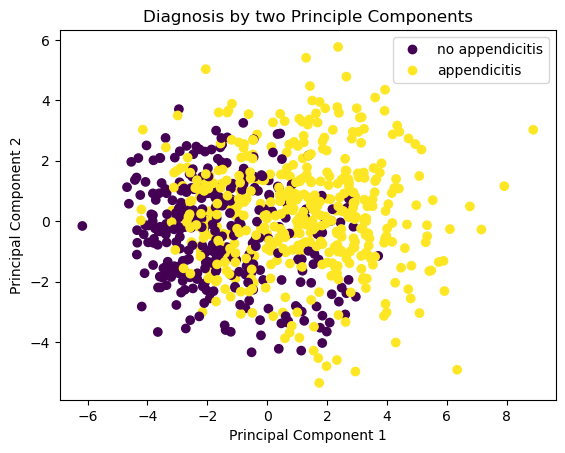

In [13]:
plot = plt.scatter(x=principalDf["pc1"], y=principalDf["pc2"], c=data["Diagnosis"])

plt.legend(handles=plot.legend_elements()[0], labels=['no appendicitis', 'appendicitis'])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Diagnosis by two Principle Components')
plt.show()

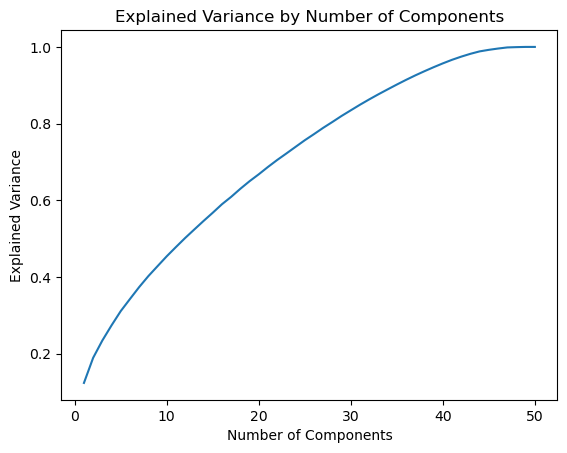

In [14]:
num_comp = []
variance = []

for i in range(1, data_features_scaled.shape[1]+1):
    number_comp = i
    
    pca = PCA(n_components=number_comp)
    principalComponents = pca.fit_transform(data_features_scaled)
    
    sum_explained_variance = pca.explained_variance_ratio_.sum()
    
    num_comp.append(number_comp)
    variance.append(sum_explained_variance)
    
plt.plot(num_comp, variance)
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

plt.show()

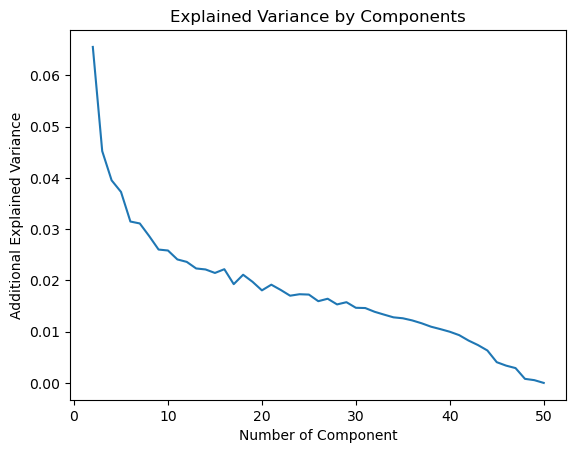

In [15]:
dif = [variance[i+1] - variance[i] for i in range(len(variance)-1)]
xs = np.arange(2,51,1)

plt.plot(xs, dif)
plt.title('Explained Variance by Components')
plt.xlabel('Number of Component')
plt.ylabel('Additional Explained Variance')
plt.show()

## Matrix Completion

In [9]:
FEATURES = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay',
       'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US',
       'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation',
       'Surrounding_Tissue_Reaction', 'Appendicular_Abscess',
       'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening',
       'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis']

data_features = data[FEATURES]

data_features_scaled = StandardScaler().fit_transform(data_features)

In [38]:
Xna = data_features_scaled

def find_nan_indices(matrix):
    r_idx, c_idx = np.where(np.isnan(matrix))
    return r_idx.tolist(), c_idx.tolist()

r_idx, c_idx = find_nan_indices(Xna)

def low_rank(X, M=1): 
    U, D, V = np.linalg.svd(X) 
    L = U[:,:M] * D[None,:M] 
    return L.dot(V[:M])

Xhat = Xna.copy()
Xbar = np.nanmean(Xhat, axis=0) 
Xhat[r_idx, c_idx] = Xbar[c_idx]

thresh = 1e-7 
rel_err = 1 
count = 0 
ismiss = np.isnan(Xna) 
mssold = np.mean(Xhat[~ismiss]**2) 
mss0 = np.mean(Xna[~ismiss ]**2)

while rel_err > thresh: 
    count += 1  
    Xapp = low_rank(Xhat, M=1) 
    Xhat[ismiss] = Xapp[ismiss] 
    mss = np.mean (((Xna - Xapp)[~ismiss]) **2) 
    rel_err = (mssold - mss) / mss0 
    mssold = mss 
    print("Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}".format(count, mss, rel_err))

Iteration: 1, MSS:0.863, Rel.Err 1.36e-01
Iteration: 2, MSS:0.861, Rel.Err 2.08e-03
Iteration: 3, MSS:0.860, Rel.Err 5.52e-04
Iteration: 4, MSS:0.860, Rel.Err 2.54e-04
Iteration: 5, MSS:0.860, Rel.Err 1.60e-04
Iteration: 6, MSS:0.860, Rel.Err 1.17e-04
Iteration: 7, MSS:0.860, Rel.Err 9.13e-05
Iteration: 8, MSS:0.859, Rel.Err 7.41e-05
Iteration: 9, MSS:0.859, Rel.Err 6.13e-05
Iteration: 10, MSS:0.859, Rel.Err 5.14e-05
Iteration: 11, MSS:0.859, Rel.Err 4.34e-05
Iteration: 12, MSS:0.859, Rel.Err 3.69e-05
Iteration: 13, MSS:0.859, Rel.Err 3.15e-05
Iteration: 14, MSS:0.859, Rel.Err 2.69e-05
Iteration: 15, MSS:0.859, Rel.Err 2.31e-05
Iteration: 16, MSS:0.859, Rel.Err 1.98e-05
Iteration: 17, MSS:0.859, Rel.Err 1.71e-05
Iteration: 18, MSS:0.859, Rel.Err 1.47e-05
Iteration: 19, MSS:0.859, Rel.Err 1.27e-05
Iteration: 20, MSS:0.859, Rel.Err 1.10e-05
Iteration: 21, MSS:0.859, Rel.Err 9.51e-06
Iteration: 22, MSS:0.859, Rel.Err 8.24e-06
Iteration: 23, MSS:0.859, Rel.Err 7.15e-06
Iteration: 24, MSS:0

In [40]:
df = pd.DataFrame(Xhat, columns=FEATURES)
df.head()

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Perforation,Surrounding_Tissue_Reaction,Appendicular_Abscess,Pathological_Lymph_Nodes,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis
0,0.379348,-0.457269,1.036566,0.000121,-0.354216,-0.499570,-0.892050,-1.151402,0.740013,-0.261491,...,0.0,1.658312,-0.550224,2.016168,-0.275431,-0.166337,-0.174307,-0.25034,-0.445148,-0.264497
1,0.781894,2.963461,-0.964724,-0.050578,1.515035,-0.888124,-0.427904,-0.640445,-1.351328,-0.680620,...,-0.0,-0.603023,-0.361204,-0.495990,-0.275431,-0.166337,-0.174307,-0.25034,2.246444,-0.264497
2,0.793234,1.002242,1.036566,0.760598,1.083669,-0.111015,-0.427904,-1.151402,-1.351328,-0.545148,...,-0.0,-0.603023,-0.289309,-0.495990,-0.275431,-0.166337,-0.174307,-0.25034,2.246444,3.780756
3,1.425401,0.386511,1.036566,0.861994,0.738577,-0.499570,0.500387,0.381467,-1.351328,-0.435673,...,-0.0,-0.603023,-0.231211,2.016168,-0.275431,-0.166337,-0.174307,-0.25034,-0.445148,3.780756
4,-0.074225,-0.457269,1.036566,0.760598,0.105907,-0.499570,-0.427904,0.381467,0.740013,-0.300953,...,-0.0,-0.603023,-0.178780,2.016168,-0.275431,-0.166337,-0.174307,-0.25034,-0.445148,3.780756
